<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

Done by :
- BENHADDAD Sabrina - Group 3 - DAC
- BENSIDHOUM Azzedine - Group 3 - DAC

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

import matplotlib.pyplot as plt


Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

# dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 205349674.97it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34472309.00it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 87385855.76it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18074505.47it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



... and visualize!

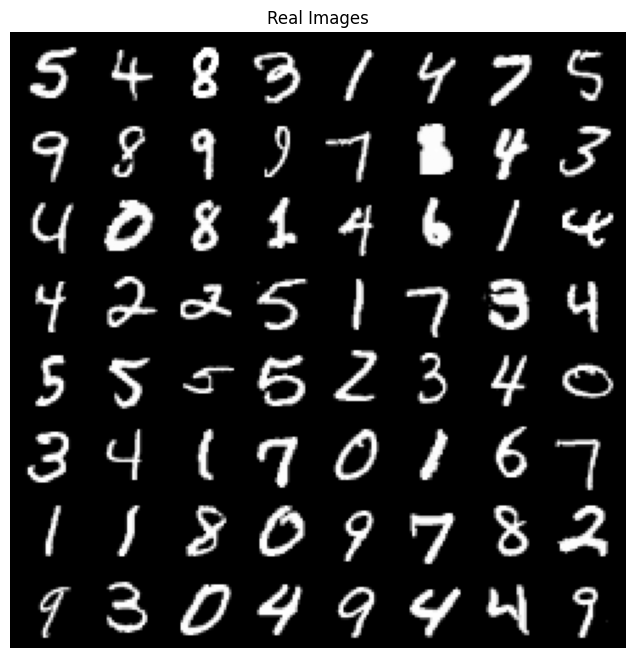

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

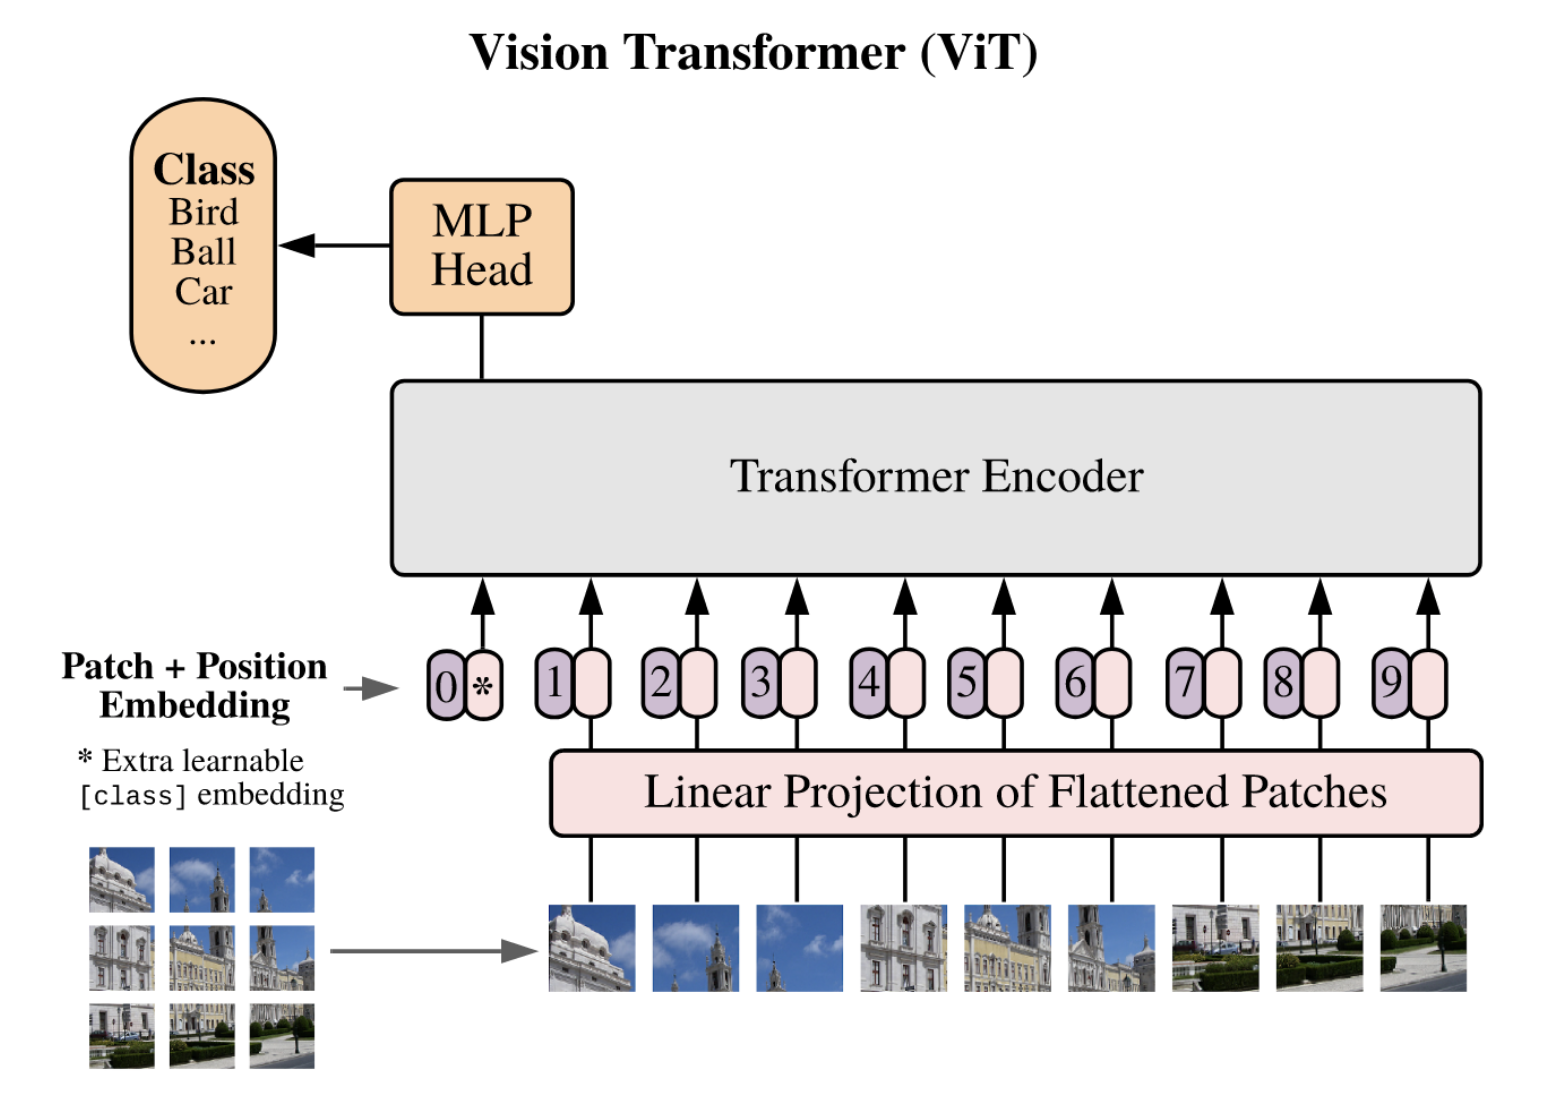

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan,embed_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self, x):
    x = self.projection(x)
    B, C, H, W = x.shape
    x = x.permute((0,2,3,1)).view((B, H*W,C))


    # x.shape -> B, N, C
    return x


batch_size = 32
channels = 1
image_height = 28
image_width = 28

patch_embed = PatchEmbed()
input_tensor = torch.randn(batch_size, channels, image_height, image_width)
output_tensor = patch_embed(input_tensor)
print(output_tensor.shape)

torch.Size([32, 16, 128])


# Transformer encoder

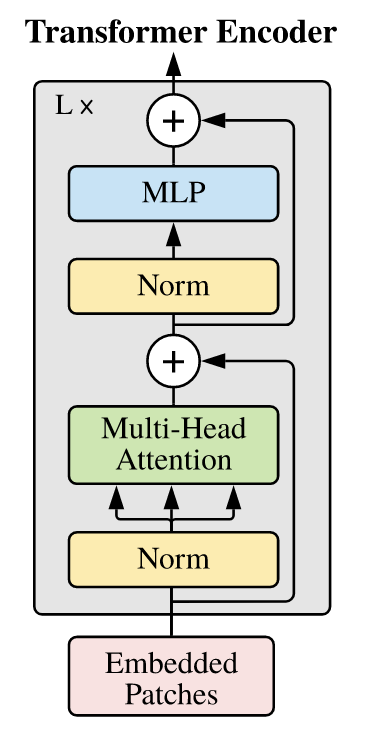

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.linear_layer1 = nn.Linear(in_features=in_features, out_features=hid_features)
    self.linear_layer2= nn.Linear(in_features=hid_features, out_features=in_features)

  def forward(self, x):
    return self.linear_layer2(F.gelu(self.linear_layer1(x)))


MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end




In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()

    # query, key, value
    self.q = nn.Linear(in_features=embed_dim, out_features=embed_dim)
    self.k = nn.Linear(in_features=embed_dim, out_features=embed_dim)
    self.v = nn.Linear(in_features=embed_dim, out_features=embed_dim)

    # final projection
    self.final_proj = nn.Linear(in_features=embed_dim, out_features=embed_dim)


  def forward(self, x):
    B, N, C = x.shape

    # TODO: compute the Q, K, V
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    # TODO: compute the attention matrix using Q and K
    attention = F.softmax((torch.bmm(q, k.permute(0, 2, 1))), dim=-1)

    # TODO: compute the final version using the attention,
    # V, and the final projection
    x = torch.bmm(attention, v)

    return self.final_proj(x)


SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [ ]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    self.head_dim = embed_dim // num_heads
    self.scale = self.head_dim ** -0.5
    self.num_heads = num_heads

    self.q = nn.Linear(in_features=embed_dim, out_features=embed_dim)
    self.k = nn.Linear(in_features=embed_dim, out_features=embed_dim)
    self.v = nn.Linear(in_features=embed_dim, out_features=embed_dim)

    # final projection
    self.projection = nn.Linear(in_features=embed_dim, out_features=embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    q = q.reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
    k = k.reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
    v = v.reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

    attention = F.softmax(q@k.permute(0, 1, 3, 2) / self.scale, dim=-1)

    x = attention@v

    x = x.permute(0, 2, 1, 3).reshape(B, N, C)

    return self.projection(x)

x = torch.randn(32, 16, 6)
MultiHeadsSelfAttention(6, 2)(x).shape

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

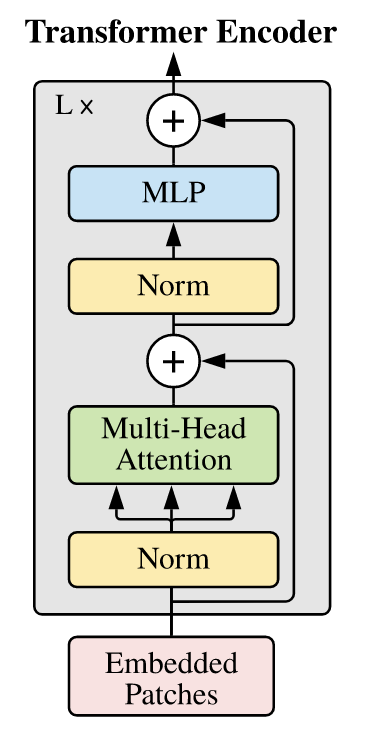

In [ ]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()

    self.layer_norm1 = nn.LayerNorm(normalized_shape=embed_dim)
    self.mae = MultiHeadsSelfAttention(embed_dim=embed_dim, num_heads=num_heads)
    self.layer_norm2 = nn.LayerNorm(normalized_shape=embed_dim)
    self.mlp = MLP(in_features=embed_dim, hid_features=(mlp_ratio*embed_dim))

  def forward(self, x):

    normed_embed_patches = self.layer_norm1(x)
    mae = self.mae(normed_embed_patches)
    residuals = mae + x

    normed_residuals = self.layer_norm2(residuals)
    mlp = self.mlp(normed_residuals)
    final_residuals = mlp + residuals

    return final_residuals

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

For PE, you can use a sinusoidal encoding (see below), or fully learned.

- Explain what is a Class token and why we use it? \\
The class token in a Vision Transformer (ViT) is a 'special token' prepended to every sequence of image patch embeddings. This token does not represent an actual image patch; rather, it is introduced as an additional, learnable embedding that is randomly initialized and updated during the training process. As the class token and the patch embeddings are passed through several encoding layers, the class token accumulates global information from all the patches. The final output from the class token embedding, having been transformed through the network, is then used as the input into a classification head during pretraining. Utilizing a randomly initialized and learnable token in this manner compels the transformer to learn to encode a 'general representation' of the entire image into that embedding, which is crucial for classification tasks.

- Explain what is the positional embedding (PE) and why it is important? \\
Transformers, by default, do not inherently account for the sequence or arrangement of input tokens or image patches. However, the concept of 'order' is critical. Consider a disassembled jigsaw puzzle: without arranging the pieces in the correct order, it's challenging to discern what picture the puzzle represents. The same principle applies to transformers.

Positional embeddings provide a solution to this limitation. In the case of Vision Transformers (ViT), these embeddings are vectors with the same dimensionality as the patch embeddings and are crucial for maintaining the spatial order of the input image patches.

The positional embeddings are appended to the patch embeddings, including the embedding of the class token, which is used for classification tasks. These embeddings are not static; they are learned during the pretraining phase of the model. As the training progresses, the positional embeddings evolve, often resulting in neighboring embeddings (particularly those in the same row or column) converging to reflect their relative positions within the grid-like structure of the image, hence capturing the spatial relationship of each patch to the others.


we add PE to not forget the strcuture of the image ( position of token in the omage)

### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
get_positional_embeddings(((28 // 7) ** 2) + 1, 128).size()

torch.Size([1, 17, 128])

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = get_positional_embeddings(num_patches + 1, embed_dim)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(in_features=embed_dim*(num_patches+1), out_features=nb_classes)

  def forward(self, x):
    x = self.patch_embed(x) ## image to patches
    B, N, C = x.shape
    ## concatenating class token
    cls_token = self.class_token.repeat(B,1,1)
    x = torch.cat([cls_token, x], dim=1)
    ## adding positional embedding
    x = x + self.pos_embed

    ## forward in the transformer
    x = self.blocks(x)

    ## Normalize the output
    x = self.norm(x)

    B, N, C = x.shape

    output = self.head(x.view(B, N*C))

    return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [ ]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()
model.pos_embed = model.pos_embed.cuda() #pos_embed is not a nn.Module so we need to move it to cuda manually
opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 0.3818183710167149
--- Epoch 1 ---
Train loss: 0.12896547447453174
--- Epoch 2 ---
Train loss: 0.09695146598223685
--- Epoch 3 ---
Train loss: 0.08097971646563966
--- Epoch 4 ---
Train loss: 0.0666123561715997
--- Epoch 5 ---
Train loss: 0.059780823474904814
--- Epoch 6 ---
Train loss: 0.050404661528662895
--- Epoch 7 ---
Train loss: 0.047160978726883816
--- Epoch 8 ---
Train loss: 0.04057527869058126
--- Epoch 9 ---
Train loss: 0.038295359447050384
Test accuracy: 97.77


# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [ ]:
from tqdm import tqdm
#For the experimentations, we will define the function below :

def train_model(embed_dim, patch_size, nb_blocks, epochs):

    model = ViT(embed_dim, nb_blocks, patch_size).cuda()
    model.pos_embed = model.pos_embed.cuda()
    opt = torch.optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        train_loss = 0.
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            opt.zero_grad()
            yhat = model(x)
            loss = F.cross_entropy(yhat, y)
            loss.backward()

            opt.step()

            train_loss += loss.item()

        # Évaluez le modèle sur l'ensemble de test à la fin de chaque époque
        test_loss = 0.
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()
                yhat = model(x)
                loss = F.cross_entropy(yhat, y)
                test_loss += loss.item()
                _, predicted = yhat.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracy = 100 * correct / total
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        train_losses.append(train_loss / len(train_loader))

    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies
    }

In [ ]:
#test
embed_dim = 32
patch_size = 7
nb_blocks = 2
epochs = 10

results = train_model(embed_dim, patch_size, nb_blocks, epochs)

# Vous pouvez maintenant accéder aux pertes d'entraînement, de test, aux précisions d'entraînement et de test dans les résultats.
train_losses = results["train_losses"]
test_losses = results["test_losses"]
train_accuracies = results["train_accuracies"]
test_accuracies = results["test_accuracies"]

100%|██████████| 10/10 [01:51<00:00, 11.14s/it]


In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies

([0.3496099694101795,
  0.12681990037801297,
  0.09708133050754889,
  0.07613184724424059,
  0.06577251404166412,
  0.056313716877958796,
  0.04899573933307343,
  0.045796718338190684,
  0.04017521487350371,
  0.03451674294544817],
 [0.13895165605494117,
  0.10489534261294559,
  0.09116893801012937,
  0.07868891446689097,
  0.08805532045249792,
  0.07043797989034012,
  0.0694299533482806,
  0.07057286437108665,
  0.0673979760171209,
  0.0779847691618083],
 [95.7, 96.7, 96.94, 97.44, 97.24, 97.83, 97.81, 97.93, 98.06, 97.66],
 [95.7, 96.7, 96.94, 97.44, 97.24, 97.83, 97.81, 97.93, 98.06, 97.66])

* Experimentations 1 : embed_dim

Training with embed_dim=16


100%|██████████| 10/10 [01:45<00:00, 10.50s/it]


Training with embed_dim=32


100%|██████████| 10/10 [01:53<00:00, 11.35s/it]


Training with embed_dim=64


100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


Training with embed_dim=128


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]


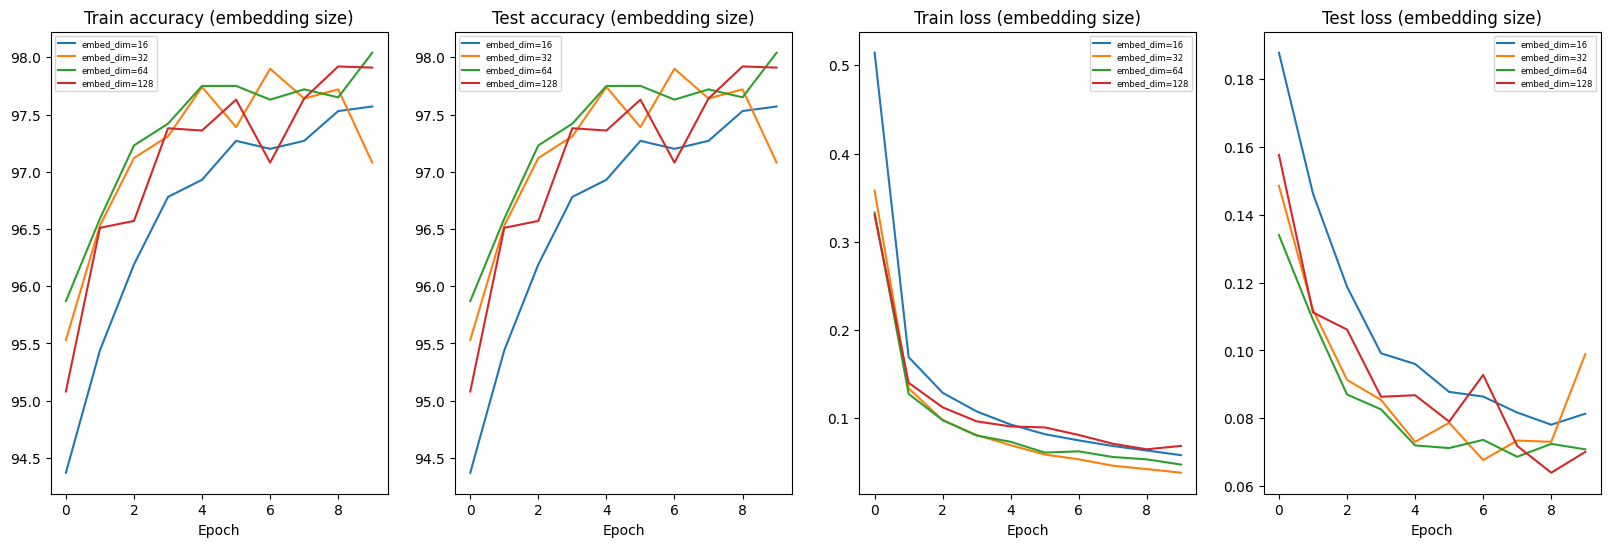

In [ ]:
embed_dim_values = [16, 32, 64, 128]
patch_size = 7
nb_blocks = 2
epochs = 10

results_dict = {
    "train_losses": [],
    "test_losses": [],
    "train_accuracies": [],
    "test_accuracies": []
}


for embed_dim in embed_dim_values:
    print(f"Training with embed_dim={embed_dim}")
    results = train_model(embed_dim, patch_size, nb_blocks, epochs)


    results_dict["train_losses"].append(results["train_losses"])
    results_dict["test_losses"].append(results["test_losses"])
    results_dict["train_accuracies"].append(results["train_accuracies"])
    results_dict["test_accuracies"].append(results["test_accuracies"])

#Plots
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.title('Train accuracy (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["train_accuracies"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 2)
plt.title('Test accuracy (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["test_accuracies"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 3)
plt.title('Train loss (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["train_losses"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 4)
plt.title('Test loss (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["test_losses"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.show()

* Experimentations 2 : patch_size

Training with embed_dim=32, patch_size=2


100%|██████████| 10/10 [03:17<00:00, 19.77s/it]


Training with embed_dim=32, patch_size=4


100%|██████████| 10/10 [02:14<00:00, 13.44s/it]


Training with embed_dim=32, patch_size=7


100%|██████████| 10/10 [01:51<00:00, 11.16s/it]


Training with embed_dim=32, patch_size=14


100%|██████████| 10/10 [02:04<00:00, 12.44s/it]


Training with embed_dim=32, patch_size=28


100%|██████████| 10/10 [01:40<00:00, 10.09s/it]


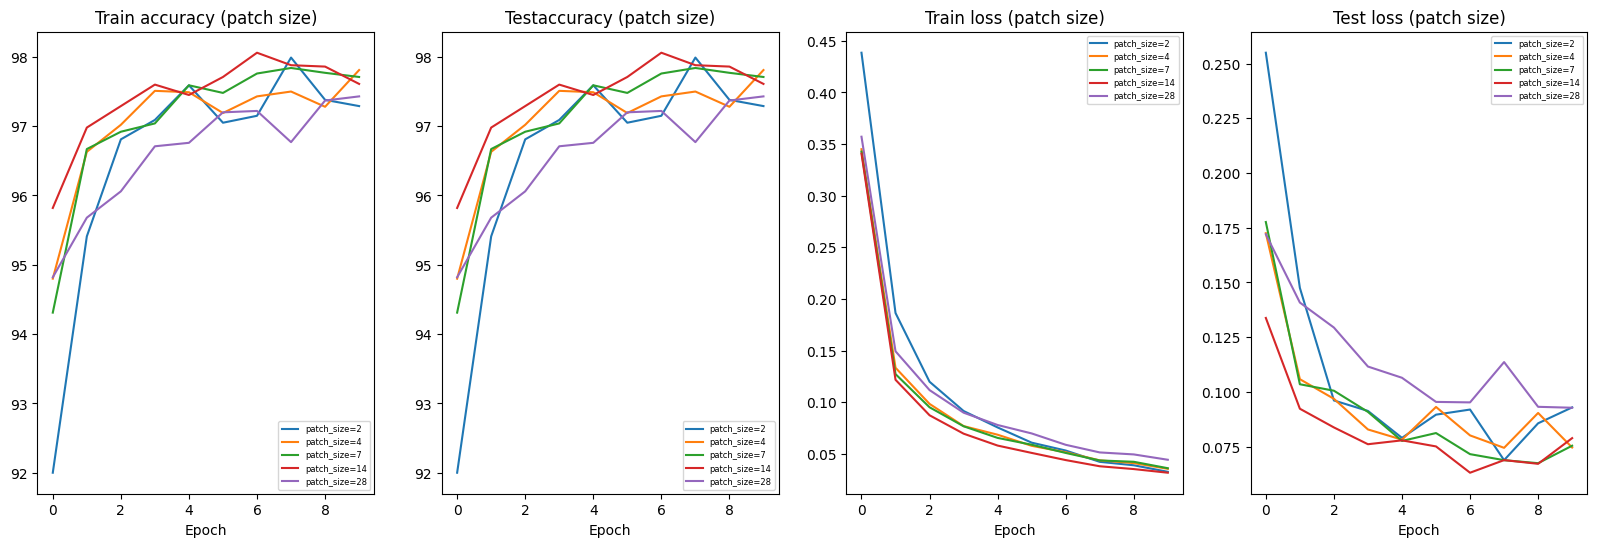

In [ ]:
patch_size_values = [2,4,7, 14, 28]
embed_dim = 32
nb_blocks = 2
epochs = 10

results_dict = {
    "train_losses": [],
    "test_losses": [],
    "train_accuracies": [],
    "test_accuracies": []
}

for patch_size in patch_size_values:
    print(f"Training with embed_dim={embed_dim}, patch_size={patch_size}")
    results = train_model(embed_dim, patch_size, nb_blocks, epochs)

    results_dict["train_losses"].append(results["train_losses"])
    results_dict["test_losses"].append(results["test_losses"])
    results_dict["train_accuracies"].append(results["train_accuracies"])
    results_dict["test_accuracies"].append(results["test_accuracies"])

# Plots
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.title('Train accuracy (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["train_accuracies"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 2)
plt.title('Testaccuracy (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["test_accuracies"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 3)
plt.title('Train loss (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["train_losses"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 4)
plt.title('Test loss (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["test_losses"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.show()

* Experimentations 3 : nb_blocks

Training with embed_dim=32, patch_size=28, nb_blocks = 2


100%|██████████| 10/10 [01:41<00:00, 10.17s/it]


Training with embed_dim=32, patch_size=28, nb_blocks = 4


100%|██████████| 10/10 [01:59<00:00, 11.97s/it]


Training with embed_dim=32, patch_size=28, nb_blocks = 6


100%|██████████| 10/10 [02:22<00:00, 14.22s/it]


Training with embed_dim=32, patch_size=28, nb_blocks = 8


100%|██████████| 10/10 [02:43<00:00, 16.37s/it]


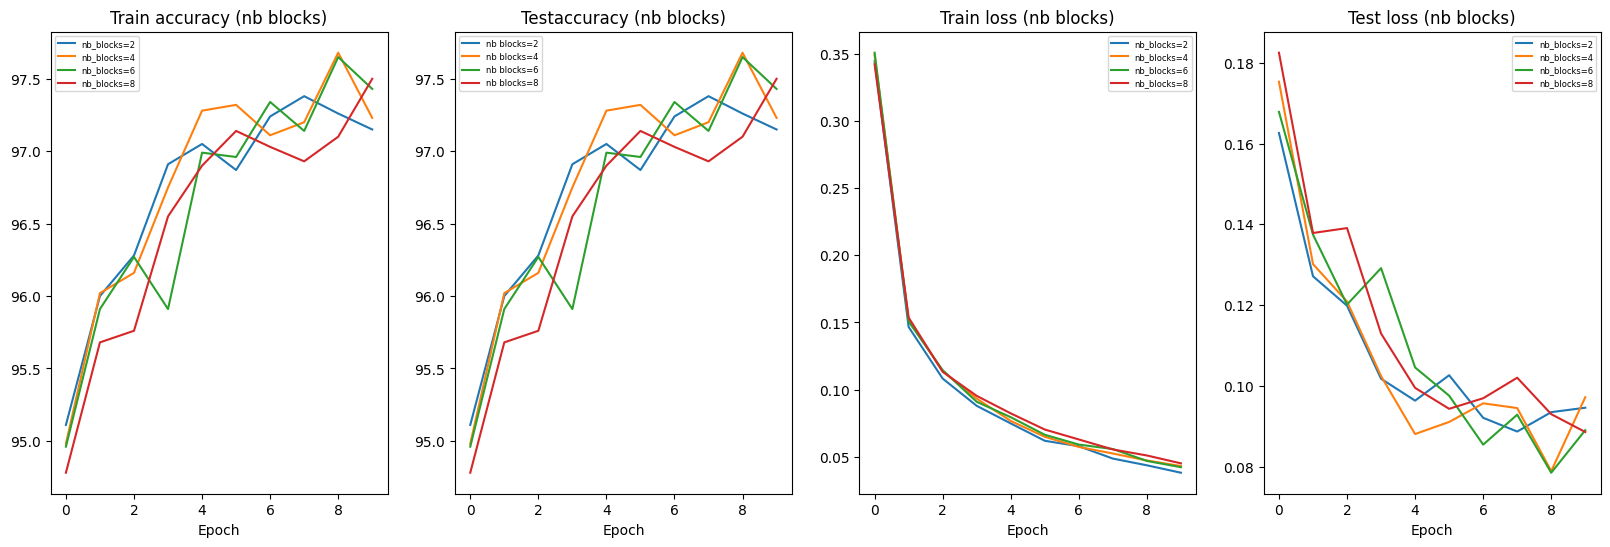

In [ ]:
nb_blocks_values = [2,4,6,8]
patch_sizes = 2
embed_dim = 32
epochs = 10

results_dict = {
    "train_losses": [],
    "test_losses": [],
    "train_accuracies": [],
    "test_accuracies": []
}


for nb_blocks in nb_blocks_values:
    print(f"Training with embed_dim={embed_dim}, patch_size={patch_size}, nb_blocks = {nb_blocks}")
    results = train_model(embed_dim, patch_size, nb_blocks, epochs)


    results_dict["train_losses"].append(results["train_losses"])
    results_dict["test_losses"].append(results["test_losses"])
    results_dict["train_accuracies"].append(results["train_accuracies"])
    results_dict["test_accuracies"].append(results["test_accuracies"])

# Plots
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.title('Train accuracy (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["train_accuracies"][i], label=f"nb_blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 2)
plt.title('Testaccuracy (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["test_accuracies"][i], label=f"nb blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 3)
plt.title('Train loss (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["train_losses"][i], label=f"nb_blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 4)
plt.title('Test loss (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["test_losses"][i], label=f"nb_blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.show()

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.9 MB/s eta 0:00:00


a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [ ]:
import timm
model = timm.create_model('vit_base_patch16_224', pretrained=False)
x=torch.randn(32, 3, 28, 28)
#model(x)

it doesn't match the image size because our vit is trained on 224*224 images in the cnn normally it works in the conv and for the dense layer part we have to delete it and replace it with conv too and pooling which have a window on the whole feature map. and also if we have the same resolution he will fail on the chanel

In [ ]:
x = torch.randn(32, 1, 28, 28)
x_proces =  F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
x_proces=x_proces.expand(-1, 3, -1, -1)
model(x_proces).shape

torch.Size([32, 1000])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True,num_classes=10,img_size=28,in_chans=1)
model(torch.randn(32, 1, 28, 28)).shape

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

torch.Size([32, 10])

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True,num_classes=10,img_size=28)
model(torch.randn(32, 3, 28, 28)).shape

torch.Size([32, 10])

c) redo the training with the pretrained ViT-S





In [ ]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:

    x, y = x.cuda(), y.cuda()
    x=x.expand(-1, 3, -1, -1)

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
import timm

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()

    x=x.expand(-1, 3, -1, -1)

    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 0.8543967946506004
--- Epoch 1 ---
Train loss: 0.4444419947832124
--- Epoch 2 ---
Train loss: 0.3892031672285564
--- Epoch 3 ---
Train loss: 0.3601344340264416
--- Epoch 4 ---
Train loss: 0.3396375525607737
--- Epoch 5 ---
Train loss: 0.3265057529435991
--- Epoch 6 ---
Train loss: 0.31065605522028167
--- Epoch 7 ---
Train loss: 0.29994296490637734
--- Epoch 8 ---
Train loss: 0.29328373595595614
--- Epoch 9 ---
Train loss: 0.2815221146956436
Test accuracy: 89.59


c) redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True,num_classes=10,img_size=28)

In [ ]:
import timm

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x=x.repeat(1, 3, 1, 1)
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()


    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 0.295325465373266
--- Epoch 1 ---
Train loss: 0.2788307699821651
--- Epoch 2 ---
Train loss: 0.2647759650847805
--- Epoch 3 ---
Train loss: 0.2619766411401315
--- Epoch 4 ---
Train loss: 0.2520465797929367
--- Epoch 5 ---
Train loss: 0.24465064904583034
--- Epoch 6 ---
Train loss: 0.23853398670456302
--- Epoch 7 ---
Train loss: 0.2284665545230227
--- Epoch 8 ---
Train loss: 0.23082006102336494
--- Epoch 9 ---
Train loss: 0.22289287441892663
Test accuracy: 90.97


d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.

The results shown indicate a decrease in training loss over the epochs, which suggests that the model is learning and improving its ability to predict the correct classes. By the final epoch, the training loss has reduced from 0.2953 in epoch 0 to 0.2228 in epoch 9. The test accuracy reported is 90.97%, which is a strong performance, especially if the dataset is challenging or the task is complex.



The application of transformer models to small datasets remains a nuanced endeavor within machine learning research. The propensity for overfitting and the intricate requirement for sufficient variance in data are significant challenges. Nevertheless, a composite approach tailored to the task's domain is pivotal.

One approach that stands as a bulwark against these challenges is transfer learning, which leverages pre-trained models as a starting point. This technique has been exemplified by Devlin et al. in their pioneering work on BERT, demonstrating that pre-trained language representations can be fine-tuned with remarkable success on smaller datasets (Devlin et al., 2018).

Data augmentation, traditionally a staple in computer vision, has found its place in natural language processing. Research by Wei and Zou (2019) has shown that augmenting text data through techniques such as synonym replacement and sentence shuffling can significantly enhance model robustness, thus compensating for the dearth of data.

In the realm of model efficiency, knowledge distillation has been a key development. The study by Sanh et al. (2019), which introduced DistilBERT, is a testament to how large transformer models can be distilled into smaller counterparts that retain a substantial portion of the original model's capabilities, making them more suited for environments with limited data.

Further, regularization methods have seen innovative applications in deep learning. Pereyra et al. (2017) suggested that penalizing over-confident predictions can act as a form of regularization, aiding in the prevention of overfitting on small datasets.

The variety of techniques outlined here, each underpinned by empirical studies, represents just a sampling of the innovative strategies enabling the use of transformer models in scenarios where data is at a premium. It's important to note that these methods are part of a broader compendium of approaches being developed and refined within the machine learning community. This burgeoning array of strategies suggests a dynamic and promising horizon for the application of transformer models, heralding their adaptability and potential across a diverse range of applications, irrespective of dataset constraints.